In [1]:
# remember to scale problem
# include CoT
# include seeds
# get proper values - length and angles
# plot tau vs speed and Fp vs speed for accuracy


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details
Stall Torque =  153.4


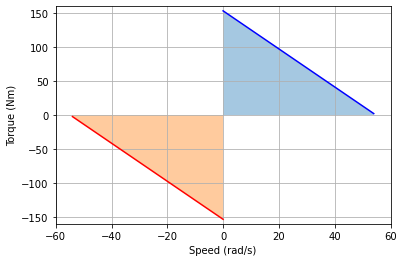

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('M1_simplified_Aug25.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] +\
           [masses[link] for link in links] +\
           [lengths[link] for link in links] +\
           [inertias[link] for link in links] +\
           [x_body]+[y_body] + [th[link] for link in links if 'foot' not in link]+[r_prismatic[link] for link in links if 'foot' in link]+\
           [dx_body]+[dy_body] + [dth[link] for link in links if 'foot' not in link]+[dr_prismatic[link] for link in links if 'foot' in link] +\
           [ddx_body]+[ddy_body] + [ddth[link] for link in links if 'foot' not in link]+[ddr_prismatic[link] for link in links if 'foot' in link] +\
           [tau['left']] + [tau['right']] +\
           [fp['left']] + [fp['right']] +\
           [grf['x','left']] + [grf['y','left']] +\
           [grf['x','right']] + [grf['y','right']]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body']

for link in links:
    if 'foot' in link:
        DOFs = DOFs + ['{{r_prismatic}}_{{{0}}}'.format(link)]
    else:
        DOFs = DOFs + ['theta_{0}'.format(link)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})

    
# PARAMETERS:
masses_ = {'body':5670/1000,
           'UL': 867/1000,
           'UR': 867/1000,
           'footL': 180/1000,
           'footR': 180/1000}

lengths_ = {'body': 24/100,
           'UL': 15.0/100,
           'UR': 15.0/100,
           'footL': 4.0/100,
           'footR': 4.0/100}

''' ****** '''
inertias_ = {'body': (masses_['body']*lengths_['body']**2)/12, # body rotate about its center 
            'UL': (masses_['UL']*lengths_['UL']**2)/12, # rotates as pendulumn ?
            'UR': (masses_['UR']*lengths_['UR']**2)/12,
            'footL': 0.0,
            'footR': 0.0}

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
links = ['body','UL','UR','footL','footR']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
feet = ['footL','footR']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}


total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

def get_var_list_zeros(m,n):
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    prismatic_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
        
    for side in sides:
                
        tau_value.update({(side): \
        BW*(m.tau_torque[n,side])})
    
        prismatic_force_value.update({(side):\
        BW*(m.Fp[n,side])})
        
    for foot in feet:
        GRF_X_value.update({(foot):BW*(m.GRF_x[n,'+ve',foot]-m.GRF_x[n,'-ve',foot])})
        GRF_Y_value.update({(foot):BW*(m.GRF_y[n,foot])})
    
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left']] + [tau_value['right']] +\
               [prismatic_force_value['left']] + [prismatic_force_value['right']] +\
               [GRF_X_value['footL']] + [GRF_Y_value['footL']] +\
               [GRF_X_value['footR']] + [GRF_Y_value['footR']]
    return var_list

'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
y_p = -2.8*x_p + 153.4
y_n = -2.8*x_n - 153.4

plt.grid()
plt.plot(x_p, y_p,'b')
plt.fill_between(x_p, y_p, alpha=0.4)

plt.plot(x_n, y_n,'r')
plt.fill_between(x_n, y_n, alpha=0.4)

plt.axis((-60,60,-160,160))
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('Stall Torque = ', 153.4)

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

<a id='time_step'></a>

In [3]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Run"}

test = tests[8]

if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.3
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Run":
    N = 50
    TT = 0.3 # 2Hz but only half a gait due to symmetry
    V_avg = 9.0
    V_flight = 0.75*sqrt(9.81*(0.18+0.35)) # from paper
    x_final = 3.0 # for display
else:
    N = 50
    TT = 0.5
    
test

'Periodic_Run'

In [4]:
total_mass

7.763999999999999

In [5]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.links = Set(initialize = links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)
m.feet = Set(initialize = feet)


#Params--------------------------
m.g = Param(initialize = 9.81)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.links, initialize = masses_)
m.lengths = Param(m.links, initialize = lengths_)
m.inertias = Param(m.links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [6]:
''' CONSTRAINTS  - Integration'''

# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [7]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.feet)
for n in range(1,N+1):
    m.foot_position[n,'Y','footL'].setlb(0.0)
    m.foot_position[n,'Y','footR'].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,foot): sym.lambdify(sym_list,r_links[foot][coordinates[wdof]],modules = [func_map])}) for foot in feet for wdof in WDOFs]

def def_foot_position(m,n,wdof,foot):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,foot] == lamb_foot_position[wdof,foot](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_position)

m.mu = Param(initialize = 10.0,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.feet, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.feet, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.feet, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.feet, bounds = (0.0,10*total_mass*m.g.value)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.feet, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(foot): sym.lambdify(sym_list,(r_links[foot].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for foot in feet]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,foot):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',foot]-m.foot_velocity[n,'X','-ve',foot] == lamb_foot_velocity_x[foot](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_velocity)

def def_friction_cone(m,n,foot):
    return m.friction_cone[n,foot] == m.mu*m.GRF_y[n,foot] - (m.GRF_x[n,'+ve',foot] + m.GRF_x[n,'-ve',foot])
m.friction_cone_constraint = Constraint(m.N, m.feet, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,foot):
    if n < N:
        return m.foot_position[n+1,'Y',foot]*m.GRF_y[n,foot] <= m.ground_penalty[n,'contact',foot]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.feet, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,foot):
    return (m.foot_velocity[n,'X','+ve',foot]+m.foot_velocity[n,'X','-ve',foot])*m.friction_cone[n,foot] <= m.ground_penalty[n,'friction',foot]
m.ground_friction_constraint = Constraint(m.N, m.feet, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,foot):
    return m.foot_velocity[n,'X','+ve',foot]*m.GRF_x[n,'+ve',foot] <= m.ground_penalty[n,'slip_+ve',foot]
m.ground_slip_positive_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,foot):
    return m.foot_velocity[n,'X','-ve',foot]*m.GRF_x[n,'-ve',foot] <= m.ground_penalty[n,'slip_-ve',foot]
m.ground_slip_negative_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_negative)

# bound contact forces at last node
for foot in feet:
    m.GRF_y[N,foot].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,foot].fix(0.0)

In [8]:
'''Torque Speed - Speed Torque Curve'''

max_torque = 38.0
max_rotational_speed = 46.0

m.tau_torque = Var(m.N, m.sides,bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides,bounds = (-max_rotational_speed,max_rotational_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side): sym.lambdify(sym_list,dr_links[motor_w_angle[side]][2],modules = [func_map])}) for side in sides]

def def_angular_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side] == lamb_tau_velocity[side](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides,rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,side):
    return m.tau_torque[n,side] <= m.tau_velocity[n,side]*(-2.8) + 153.4
m.constant_power_right_constraint = Constraint(m.N, m.sides,rule = def_constant_power_right)

def def_constant_power_left(m,n,side):
    return m.tau_torque[n,side] >= m.tau_velocity[n,side]*(-2.8) - 153.4
m.constant_power_left_constraint = Constraint(m.N, m.sides,rule = def_constant_power_left)

In [9]:
# m.Fp = Var(m.N, m.sides, bounds = (-total_mass*9.81,total_mass*9.81))

# Fo = 5*(total_mass*9.81) = 383N

# given the torque speed curve, what radius should the pinion be such that Fo = 383N?
Tau_stall = 153.4 # using the equation: y_p = -2.8*x_p + 153.4
pinion_radius = 0.4 # T = F*d
Fo = Tau_stall/pinion_radius # stall force
# max_power = max_torque*max_rotational_speed # Tau_max*w_max    https://www.clear.rice.edu/elec201/Book/motors.html 
max_power = (153.4*54.8)/4
Fp_max = max_torque/pinion_radius
m.Fp = Var(m.N, m.sides,bounds = (-Fp_max,Fp_max))


max_translational_speed = max_rotational_speed*pinion_radius 
m.Fp_velocity = Var(m.N, m.sides,bounds = (-max_translational_speed,max_translational_speed))


lamb_Fp_velocity = {}
lamb_Fp_velocity.update({('left'): sym.lambdify(sym_list,dq[5],modules = [func_map])})
lamb_Fp_velocity.update({('right'): sym.lambdify(sym_list,dq[6],modules = [func_map])})


def def_Fp_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.Fp_velocity[n,side] == lamb_Fp_velocity[side](*var_list)   
m.Fp_velocity_constraint = Constraint(m.N, m.sides, rule = def_Fp_velocity)

# assume straight line
def def_Fp_right(m,n,side):
    return m.Fp[n,side] <= Fo*(1-((Fo/(4*max_power))*m.Fp_velocity[n,side]))
m.Fp_right_constraint = Constraint(m.N, m.sides,rule = def_Fp_right)

def def_Fp_left(m,n,side):
    return m.Fp[n,side] >= Fo*(-1-((Fo/(4*max_power))*m.Fp_velocity[n,side]))
m.Fp_left_constraint = Constraint(m.N, m.sides,rule = def_Fp_left)

<a id='constraints'></a>

In [10]:
# Get the foot position in WDOF
if test == "Periodic_Run" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_links['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    
    if test == "Periodic_Run":
        
        # Average velocities
        def def_body_position_average(m,wdof):
            if wdof == 'X':
                return (m.body_position[N,'X'] - m.body_position[1,'X'])/(sum(hm*m.h[n] for n in range(1,N+1))) == V_avg
            else: return Constraint.Skip
        m.def_body_position_average_constraint = Constraint(m.WDOFs, rule = def_body_position_average)
        
        # Equate states
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'y_body' or dof_i == 'theta_body':
                return m.q[1,dof_i] == m.q[N,dof_i]
            elif dof_i == '{r_prismatic}_{footL}':
                return m.q[1,'{r_prismatic}_{footL}'] == m.q[N,'{r_prismatic}_{footR}']
            elif dof_i == '{r_prismatic}_{footR}':
                return m.q[1,'{r_prismatic}_{footR}'] == m.q[N,'{r_prismatic}_{footL}']
            elif dof_i == 'theta_UL':
                return m.q[1,'theta_UL'] == m.q[N,'theta_UR']
            elif dof_i == 'theta_UR':
                return m.q[1,'theta_UR'] == m.q[N,'theta_UL']
            else: 
                 return Constraint.Skip
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states) 

        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
  
    
        # Condition where the GRF can't increase twice from zero          
    
    
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


In [11]:
''' Use this code for tests '''

# BOUND VALUES
for n in range(1,N+1):
    m.q[n,'theta_body'].setub(np.pi*(1/4))
    m.q[n,'theta_body'].setlb(np.pi*(-1/4))
    
    # 0.15 - 0.5 = 0.35
    
    m.q[n,'{r_prismatic}_{footL}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footL}'].setub(0.35)
    m.q[n,'{r_prismatic}_{footR}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footR}'].setub(0.35)
    
    m.q[n,'theta_UL'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UL'].setub(np.pi*(1/3))
    m.q[n,'theta_UR'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UR'].setub(np.pi*(1/3))
        
    if test == "Periodic_Run":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
#         m.dq[1,'theta_UL'].fix(0.0)
#         m.dq[1,'theta_UR'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
        
        if test == "Drop_Hop_Test" or "Periodic_Hop":
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]
            
        else:
            [m.tau_torque[n,side].fix(0.0) for side in sides]
            [m.Fp[n,side].fix(0.0) for side in sides]
    else:
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Run":
            pass
        else:
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]

<a id='initial_conditions'></a>

In [12]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.3)
    m.q[1,'y_body'].fix(1.3)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
    m.q[1,'theta_UL'].fix(np.pi*(-2/9))
    m.q[1,'theta_UR'].fix(np.pi*(2/9))
        
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(-1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[1, 'Y', 'footL'].fix(0.2)
    m.foot_position[1, 'Y', 'footR'].fix(0.2)
    
#     m.q[N,'x_body'].setub(0.7)
#     m.q[N,'x_body'].setlb(0.3)

        
# elif test == "Hop_Test":
#     #  ----------------------------- HOP TEST ---------------------------

#     # initial condition
#     m.q[1,'y_body'].fix(0.35)
#     m.q[1,'x_body'].fix(0.0)
#     m.q[1,'theta_body'].fix(np.pi*(0.0))
#     m.foot_position[1, 'Y', 'A'].fix(0.0)
#     m.foot_position[1, 'Y', 'B'].fix(0.0)
#     m.foot_position[1, 'X', 'A'].fix(-0.2)
#     m.foot_position[1, 'X', 'B'].fix(0.2)
        
#     m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(-1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[round(N/5), 'Y', 'footL'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'footR'].setub(0.05)
    
    m.q[N,'theta_UL'].setub(np.pi*(1/6))
    m.q[N,'theta_UR'].setlb(np.pi*(1/6))
    
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)   
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
     
    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footL'].value = m.mu.value*m.GRF_y[n,'footL'].value
        m.GRF_y[n,'footR'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footR'].value = m.mu.value*m.GRF_y[n,'footR'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.0))
    m.q[1,'theta_UR'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    m.dq[N,'theta_UL'].fix(0.0)
    m.dq[N,'theta_UR'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)
    m.q[N,'theta_UL'].fix(np.pi*(0.0))
    m.q[N,'theta_UR'].fix(np.pi*(0.0))

    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.5))
    m.q[1,'theta_UR'].fix(np.pi*(0.5))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    

elif test == "Periodic_Run":
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,TT*V_avg,N)
    for n in range(1,N+1):
        m.q[n,'x_body'].value = guide[n-1] #+ np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)

#         m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#         m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].setlb(np.pi*(-1/6))
    m.q[1,'theta_UL'].setub(np.pi*(-1/12))
    
    m.q[1,'theta_UR'].setub(np.pi*(1/6))
    m.q[1,'theta_UR'].setlb(np.pi*(1/12))
    
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].fix(0.0)
        m.foot_position[n, 'Y', 'footL'].setlb(0.05)
    
    m.GRF_y[1,'footR'].fix(0.0)
    
    
    
    
#     """ ******** CANNOT CHANGE ORDER OF phases ********* """
#     phases = ['flight','stance']
    
#     phase_times = {}
       
#     phase_times.update({('left','flight'): 25})
#     phase_times.update({('left','stance'): 25})
#     phase_times.update({('right','flight'): 25})
#     phase_times.update({('right','stance'): 25})
    
#     timing_diagram = {}
#     timer = 0
    
#     for side in sides:
#         for phase in phases:
#             timer = timer + round(N*(phase_times[side,phase]/100))
#             timing_diagram.update({(side,phase): timer})
    
#     min_height = 0.005
#     min_GRF = 0.05
    
#     for left_flight in range (1,timing_diagram['left','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for left_stance in range (timing_diagram['left','flight']+1,timing_diagram['left','stance']+1):
#         # left foot down
#         m.GRF_y[left_stance,'footR'].fix(0.0)
#         m.foot_position[left_stance, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_stance, 'Y', 'footL'].fix(0.0)
        
#     for right_flight in range (timing_diagram['left','stance']+1,timing_diagram['right','flight']+1):
#         m.GRF_y[left_flight,'footL'].fix(0.0)
#         m.GRF_y[left_flight,'footR'].fix(0.0)
#         m.foot_position[left_flight, 'Y', 'footR'].setlb(min_height)
#         m.foot_position[left_flight, 'Y', 'footL'].setlb(min_height)
        
#     for right_stance in range (timing_diagram['right','flight']+1,timing_diagram['right','stance']+1):
#         # right foot down
#         m.GRF_y[right_stance,'footL'].fix(0.0)
#         m.foot_position[right_stance, 'Y', 'footL'].setlb(min_height)
#         m.foot_position[right_stance, 'Y', 'footR'].fix(0.0)
    
else: pass

<a id='cost_function'></a>

In [13]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    actuation_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
    
    T = sum(m.h[n] for n in range(1,N+1))
    for n in range(1,N+1):
            for side in sides:
                actuation_sum += (m.tau_torque[n,side])**2 + (m.Fp[n,side])**2
                
                if test == "Periodic_Run":
                    transport_sum += ((m.tau_torque[n,side])**2 + (m.Fp[n,side])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for foot in feet:
                    pen_sum += m.ground_penalty[n,gc,foot] 
                    
    if test == "Periodic_Run":
        return row*pen_sum + actuation_sum/100 #+ transport_sum 
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [14]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_UL(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UL'](*var_list) == 0
m.EOM_th_UL_constraint = Constraint(m.N, rule = EOM_th_UL)

def EOM_th_UR(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UR'](*var_list) == 0
m.EOM_th_UR_constraint = Constraint(m.N, rule = EOM_th_UR)

def EOM_r_prismatic_footL(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footL}'](*var_list) == 0
m.EOM_r_prismatic_footL_constraint = Constraint(m.N, rule = EOM_r_prismatic_footL)

def EOM_r_prismatic_footR(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footR}'](*var_list) == 0
m.EOM_r_prismatic_footR_constraint = Constraint(m.N, rule = EOM_r_prismatic_footR)

In [15]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*2   # maximum number of iterations
opt.options["max_cpu_time"] = 600*2  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=60000
max_cpu_time=1200
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    12147
Number of nonzeros in inequality constraint Jacobian.:     1986
Number of nonzeros in Lagrangian Hessian.............:     6516

Total number of variables............................:     2691
                     variables with only lower bounds:      400
                variables with lower and upper bounds:     1343
                     variables with only up

  81r 3.9939159e+06 9.78e-01 4.79e+02  -5.6 2.03e+01  -3.9 1.04e-01 1.96e-01f  1
  82r 4.3721859e+06 9.79e-01 4.20e+02  -5.6 5.21e+01  -4.4 1.23e-01 1.18e-01f  1
  83r 4.5570370e+06 9.80e-01 4.09e+02  -5.6 6.95e+02  -4.9 2.94e-02 4.42e-02f  1
  84r 4.5639738e+06 9.80e-01 3.70e+02  -5.6 7.09e+02  -5.4 9.69e-02 1.84e-03h  1
  85r 5.3223910e+06 9.82e-01 3.30e+02  -5.6 1.07e+02  -4.9 8.88e-02 2.31e-01f  1
  86r 5.4031699e+06 9.82e-01 3.20e+02  -5.6 3.40e+03  -5.4 3.62e-02 1.47e-02h  1
  87r 6.2506373e+06 9.84e-01 2.70e+02  -5.6 1.08e+02  -5.0 7.68e-02 3.34e-01f  1
  88r 6.3550305e+06 9.84e-01 2.41e+02  -5.6 1.47e+02  -5.5 1.69e-01 5.90e-02f  1
  89r 6.5668165e+06 9.85e-01 1.87e+02  -5.6 1.77e+02  -5.9 3.37e-01 1.26e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 6.9143190e+06 9.86e-01 1.54e+02  -5.6 1.29e+02  -5.5 4.35e-02 2.41e-01h  1
  91r 7.4072684e+06 9.88e-01 7.44e+01  -5.6 7.39e+01  -5.1 6.12e-01 4.64e-01h  1
  92r 7.8605420e+06 9.89e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 7.0340870e+06 9.87e-01 5.24e+01  -5.6 2.74e+02  -4.7 9.28e-02 1.12e-01f  1
 221r 7.0038358e+06 9.87e-01 4.47e+00  -5.6 1.59e+02  -4.2 1.65e-01 7.12e-01f  1
 222r 7.0030889e+06 9.87e-01 1.73e+01  -5.6 5.73e+01  -3.8 8.51e-01 2.54e-01h  1
 223r 7.0027921e+06 9.87e-01 3.07e+01  -5.6 1.35e+02  -4.3 6.71e-01 4.04e-02h  1
 224r 7.0035326e+06 9.87e-01 2.27e+01  -5.6 5.92e+01  -3.9 9.17e-01 7.02e-02h  1
 225r 7.0041750e+06 9.87e-01 2.02e+01  -5.6 1.50e+02  -4.3 3.27e-02 9.40e-02f  1
 226r 7.0064917e+06 9.87e-01 1.72e+01  -5.6 6.73e+01  -3.9 2.65e-01 1.52e-01h  1
 227r 7.0061237e+06 9.87e-01 3.46e+01  -5.6 1.99e+03  -4.4 3.01e-02 4.24e-03f  1
 228r 7.0108311e+06 9.87e-01 2.49e+01  -5.6 7.83e+01  -4.0 1.40e-01 2.16e-01h  1
 229r 7.0158581e+06 9.87e-01 2.96e+01  -5.6 3.09e+01  -3.5 1.00e+00 2.27e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 7.0215105e+06 9.87e-01

 357r 7.4775924e+06 9.86e-01 5.34e+01  -5.6 1.66e+02  -4.0 4.58e-02 1.97e-01f  1
 358r 7.4895483e+06 9.86e-01 2.24e+02  -5.6 1.18e+03  -4.5 7.21e-04 9.54e-02f  1
 359r 7.5141023e+06 9.86e-01 2.47e+02  -5.6 8.15e+01  -3.2 2.07e-02 5.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360r 7.5385614e+06 9.86e-01 2.16e+02  -5.6 3.49e+01  -2.7 2.86e-02 1.24e-01h  1
 361r 7.5274732e+06 9.86e-01 2.02e+02  -5.6 6.64e+01  -3.2 4.73e-02 6.03e-02h  1
 362r 7.5206280e+06 9.86e-01 2.04e+02  -5.6 2.63e+02  -3.7 1.80e-02 1.62e-02f  1
 363r 7.5056325e+06 9.86e-01 1.99e+02  -5.6 6.91e+01  -3.3 1.57e-01 8.89e-02f  1
 364r 7.4483493e+06 9.88e-01 9.53e+01  -5.6 2.31e+02  -3.7 4.07e-02 1.14e-01f  1
 365r 7.3888871e+06 9.89e-01 1.53e+02  -5.6 6.65e+01  -3.3 3.55e-02 3.16e-01f  1
 366r 7.3619456e+06 9.90e-01 2.94e+02  -5.6 1.70e+02  -3.8 2.68e-02 8.59e-02f  1
 367r 7.3424337e+06 9.91e-01 2.57e+02  -5.6 6.89e+01  -3.4 9.00e-02 1.22e-01f  1
 368r 7.3359301e+06 9.91e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450r 7.0878750e+06 1.01e+00 7.23e+01  -5.6 3.33e+01  -3.2 1.40e-01 4.44e-01f  1
 451r 7.0935414e+06 1.01e+00 6.27e+01  -5.6 1.24e+01  -2.8 9.42e-01 2.47e-01h  1
 452r 7.1022645e+06 1.01e+00 1.03e+02  -5.6 8.22e+01  -3.3 3.03e-01 6.21e-02f  1
 453r 7.0883734e+06 1.01e+00 3.59e+00  -5.6 1.69e+01  -2.8 8.15e-01 1.00e+00f  1
 454r 7.0886375e+06 1.01e+00 2.25e+01  -5.6 7.71e+00  -2.4 2.39e-01 3.61e-01h  1
 455r 7.0858524e+06 1.01e+00 4.54e+01  -5.6 2.79e+01  -2.9 7.49e-01 4.80e-01f  1
 456r 7.0799982e+06 1.01e+00 3.29e+01  -5.6 2.38e+02  -3.4 5.88e-02 9.02e-02f  1
 457r 7.0686649e+06 1.01e+00 3.08e+01  -5.6 4.34e+02  -3.9 3.63e-02 4.81e-02f  1
 458r 7.0617061e+06 1.01e+00 3.07e+01  -5.6 1.14e+03  -4.3 6.45e-03 4.95e-03f  1
 459r 7.0450187e+06 1.01e+00 3.13e+01  -5.6 2.32e+02  -3.9 9.39e-02 1.32e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r 7.0451427e+06 1.01e+00

 587r 6.7645463e+06 9.92e-01 2.68e+01  -5.6 6.03e+01  -3.9 1.85e-01 3.84e-02h  1
 588r 6.7661948e+06 9.92e-01 2.67e+01  -5.6 3.28e+03  -4.4 5.71e-04 2.12e-03f  1
 589r 6.7646624e+06 9.92e-01 2.60e+01  -5.6 1.10e+02  -4.0 1.23e-01 2.91e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590r 6.7328641e+06 9.90e-01 3.22e+01  -5.6 2.40e+01  -3.6 6.46e-02 5.02e-01h  1
 591r 6.7382285e+06 9.89e-01 3.90e+01  -5.6 7.39e+03  -4.0 2.34e-03 8.30e-04f  1
 592r 6.7385789e+06 9.89e-01 1.53e+02  -5.6 4.77e+01  -3.6 1.00e+00 4.02e-02h  1
 593r 6.7208474e+06 9.87e-01 8.00e+01  -5.6 1.26e+01  -3.2 3.33e-01 1.00e+00h  1
 594r 6.7390097e+06 9.86e-01 1.26e+02  -5.6 2.01e+02  -3.7 1.51e-01 6.03e-02f  1
 595r 6.8053104e+06 9.82e-01 4.44e+00  -5.6 3.39e+01  -3.2 1.00e+00 1.00e+00f  1
 596r 6.8084503e+06 9.82e-01 4.37e+00  -5.6 2.73e+01  -2.8 7.22e-03 1.53e-02h  1
 597r 6.8074891e+06 9.81e-01 2.03e+02  -5.6 8.30e+00  -2.4 7.26e-01 1.30e-01f  1
 598r 6.8174051e+06 9.80e-01

In iteration 724, 1 Slack too small, adjusting variable bound
 725r 8.2491607e+06 7.80e-01 4.00e+02  -7.0 2.91e+03  -4.5 3.65e-03 1.17e-06f  1
 726r 8.2605669e+06 7.78e-01 3.98e+02  -7.0 3.06e+02  -4.1 1.61e-02 5.41e-03f  1
 727r 8.2727861e+06 7.74e-01 3.98e+02  -7.0 8.86e+03  -4.6 6.13e-08 7.23e-04f  1
 728r 8.2731261e+06 7.74e-01 3.98e+02  -7.0 3.37e+02  -4.1 6.34e-02 2.48e-04f  1
 729r 8.2854993e+06 7.71e-01 3.93e+02  -7.0 1.51e+02  -3.7 6.12e-03 1.12e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730r 8.2983087e+06 7.66e-01 3.90e+02  -7.0 3.71e+02  -4.2 6.79e-03 9.48e-03f  1
 731r 8.2959663e+06 7.63e-01 3.87e+02  -7.0 2.36e+02  -3.8 1.05e-01 6.36e-03f  1
 732r 8.3050195e+06 7.60e-01 3.79e+02  -7.0 7.99e+01  -3.3 5.02e-02 2.05e-02f  1
 733r 8.3037058e+06 7.59e-01 3.79e+02  -7.0 2.79e+02  -3.8 2.47e-04 1.64e-03f  1
 734r 8.3144534e+06 7.56e-01 3.69e+02  -7.0 8.97e+01  -3.4 8.97e-03 2.51e-02f  1
 735r 8.3127626e+06 7.55e-01 3.68e+02  -7.0 3.1

 816r 8.8306627e+06 4.24e-01 1.20e+02  -7.0 3.31e+01  -2.8 2.05e-02 1.17e-01f  1
 817r 8.8330642e+06 4.23e-01 1.42e+02  -7.0 1.07e+01  -2.3 1.35e-02 1.06e-01h  1
 818r 8.8344141e+06 4.23e-01 1.39e+02  -7.0 3.92e+01  -2.8 7.29e-02 2.28e-02f  1
 819r 8.8353472e+06 4.22e-01 1.29e+02  -7.0 1.20e+01  -2.4 1.84e-02 7.26e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820r 8.8361338e+06 4.22e-01 1.28e+02  -7.0 4.95e+01  -2.9 2.52e-02 7.14e-03h  1
 821r 8.8431792e+06 4.20e-01 9.56e+01  -7.0 1.37e+01  -2.4 2.93e-02 2.52e-01f  1
 822r 8.8482985e+06 4.18e-01 9.11e+01  -7.0 5.44e+01  -2.9 1.96e-02 4.70e-02f  1
 823r 8.8565356e+06 4.16e-01 6.74e+01  -7.0 1.60e+01  -2.5 3.82e-01 2.61e-01f  1
 824r 8.8620641e+06 4.14e-01 6.39e+01  -7.0 5.58e+01  -3.0 8.42e-02 5.14e-02f  1
 825r 8.8728138e+06 4.10e-01 6.27e+01  -7.0 3.53e+02  -3.5 1.13e-02 1.87e-02f  1
 826r 8.8737356e+06 4.10e-01 6.21e+01  -7.0 5.59e+01  -3.0 2.90e-01 9.31e-03f  1
 827r 8.8812526e+06 4.06e-01

 956  9.6238384e+06 6.41e-02 5.25e+03  -1.0 1.15e+04    -  4.47e-04 4.17e-04f  1
 957  9.4996799e+06 6.40e-02 5.25e+03  -1.0 1.29e+04    -  5.68e-04 1.77e-03f  1
 958  9.4138996e+06 6.39e-02 5.25e+03  -1.0 1.42e+04    -  6.57e-04 1.28e-03f  1
 959  9.3162909e+06 6.38e-02 5.25e+03  -1.0 1.49e+04    -  2.87e-04 1.48e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960  9.2526412e+06 6.37e-02 5.25e+03  -1.0 1.60e+04    -  4.00e-04 9.51e-04f  1
 961  9.1006304e+06 6.36e-02 5.26e+03  -1.0 1.77e+04    -  3.40e-04 2.16e-03f  1
 962  9.0333562e+06 6.35e-02 5.26e+03  -1.0 1.97e+04    -  5.52e-04 8.49e-04f  1
 963  8.9207506e+06 6.35e-02 5.26e+03  -1.0 2.05e+04    -  4.72e-04 1.24e-03f  1
 964  8.9177393e+06 6.35e-02 5.25e+03  -1.0 1.82e+04    -  7.36e-04 3.73e-05f  1
 965  8.7336904e+06 6.34e-02 5.26e+03  -1.0 1.96e+04    -  1.32e-04 1.77e-03f  1
 966  8.5767513e+06 6.33e-02 5.26e+03  -1.0 2.44e+04    -  5.39e-04 1.17e-03f  1
 967  8.3098052e+06 6.32e-02

1049  1.4019768e+06 3.06e+00 3.49e+05  -1.0 4.16e+01   0.3 5.86e-03 7.53e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050  1.4130680e+06 3.01e+00 3.43e+05  -1.0 7.26e+01  -0.2 1.84e-02 1.59e-02h  1
1051  1.4778661e+06 2.90e+00 3.24e+05  -1.0 1.50e+02  -0.7 1.39e-02 3.57e-02h  1
1052  1.4878939e+06 2.90e+00 3.29e+05  -1.0 1.11e+03  -1.2 1.25e-02 1.75e-03h  1
1053  1.5418027e+06 2.82e+00 3.20e+05  -1.0 2.00e+02  -0.7 2.44e-02 2.64e-02h  1
1054  1.5422472e+06 2.82e+00 3.30e+05  -1.0 5.16e+02  -1.2 1.84e-02 2.47e-04h  1
1055  1.5419838e+06 2.78e+00 3.35e+05  -1.0 2.29e+02  -1.7 2.51e-02 1.20e-02f  1
1056  1.5418566e+06 2.77e+00 3.40e+05  -1.0 4.74e+02  -2.2 1.49e-02 4.77e-03f  1
1057  1.5417192e+06 2.73e+00 3.26e+05  -1.0 8.80e+02  -2.6 2.97e-03 1.57e-02f  1
1058  1.5417775e+06 2.73e+00 5.81e+05  -1.0 1.72e+03  -3.1 1.25e-01 2.10e-03h  1
1059  1.5401697e+06 2.69e+00 5.48e+05  -1.0 2.00e+03  -3.6 1.21e-02 1.77e-02f  1
iter    objective    inf_pr 

1141  2.5027798e+06 2.41e-02 4.46e+05  -1.0 4.22e+01   0.6 6.45e-01 3.62e-01h  1
1142  2.5272238e+06 2.40e-02 4.50e+05  -1.0 1.21e+02   0.1 8.48e-02 4.30e-02h  1
1143  2.5283279e+06 2.38e-02 4.53e+05  -1.0 4.81e+01   0.6 1.77e-02 8.29e-03h  1
1144  2.5351068e+06 2.35e-02 4.70e+05  -1.0 1.83e+02   0.1 5.73e-02 1.26e-02h  5
1145  2.5929622e+06 2.02e-02 8.09e+04  -1.0 5.33e+01   0.5 2.90e-02 2.71e-01H  1
1146  2.6119130e+06 1.69e-02 2.50e+05  -1.0 2.05e+01   0.9 3.67e-01 1.95e-01h  1
1147  2.6252675e+06 1.66e-02 2.28e+05  -1.0 7.21e+01   0.5 1.23e-02 2.92e-02h  2
1148  2.6355502e+06 1.56e-02 1.97e+05  -1.0 2.28e+01   0.9 5.22e-02 6.91e-02h  1
1149  2.6420124e+06 1.55e-02 1.97e+05  -1.0 1.47e+02   0.4 9.66e-03 7.64e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150  2.7129681e+06 1.49e-02 1.78e+05  -1.0 2.53e+01   0.8 3.80e-01 3.32e-01h  1
1151  2.7187443e+06 1.42e-02 5.51e+05  -1.0 9.62e+00   1.3 4.36e-01 4.87e-02h  1
1152  2.7411873e+06 1.37e-02

1234  9.1116673e+05 7.73e-01 1.21e+04  -2.5 2.28e+04    -  2.12e-03 5.43e-03f  1
1235  9.0718574e+05 7.74e-01 1.21e+04  -2.5 2.34e+04    -  1.09e-03 1.81e-03f  1
1236  9.0305728e+05 7.76e-01 1.21e+04  -2.5 2.32e+04    -  1.60e-03 1.90e-03f  1
1237  8.9763572e+05 7.80e-01 1.22e+04  -2.5 2.32e+04    -  1.67e-03 2.65e-03f  1
1238  8.9740925e+05 7.79e-01 1.14e+04  -2.5 2.45e+04    -  6.37e-03 1.27e-04f  1
1239  8.9006688e+05 7.93e-01 1.15e+04  -2.5 2.53e+04    -  3.34e-03 4.49e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240  8.8555685e+05 7.96e-01 1.17e+04  -2.5 2.54e+04    -  1.23e-03 2.57e-03f  1
1241  8.7299152e+05 8.31e-01 1.20e+04  -2.5 2.54e+04    -  3.45e-03 6.87e-03f  1
1242  8.5885477e+05 8.73e-01 1.23e+04  -2.5 2.52e+04    -  4.82e-03 7.46e-03f  1
1243  8.5463240e+05 8.75e-01 1.25e+04  -2.5 2.51e+04    -  3.64e-05 2.15e-03f  1
1244  8.4705785e+05 8.84e-01 1.15e+04  -2.5 2.52e+04    -  1.14e-02 3.71e-03f  1
1245  8.4100826e+05 8.89e-01

1327  6.0196483e+05 3.04e+00 1.23e+05  -2.5 6.80e+03  -4.1 2.83e-02 1.23e-03h  1
1328  6.0373665e+05 3.02e+00 1.26e+05  -2.5 2.74e+04  -4.6 8.36e-03 2.92e-03h  1
1329  6.0648627e+05 2.99e+00 1.14e+05  -2.5 7.69e+03  -4.2 1.60e-04 1.47e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1330  6.0686167e+05 2.99e+00 1.16e+05  -2.5 5.10e+04  -4.6 5.43e-03 3.63e-04h  1
1331  6.1008713e+05 2.96e+00 1.07e+05  -2.5 8.58e+03  -4.2 2.87e-03 1.36e-02h  1
1332  6.1040288e+05 2.96e+00 1.07e+05  -2.5 3.65e+04  -4.7 5.48e-05 2.92e-04h  1
1333  6.1133185e+05 2.95e+00 1.31e+05  -2.5 9.68e+03  -4.3 3.57e-02 2.52e-03h  1
1334  6.1376905e+05 2.94e+00 1.30e+05  -2.5 1.19e+04  -4.7 3.55e-03 4.18e-03h  1
1335  6.1449288e+05 2.94e+00 1.30e+05  -2.5 1.52e+04  -5.2 1.99e-03 1.02e-03h  1
1336  6.1474939e+05 2.92e+00 1.31e+05  -2.5 3.99e+01  -0.3 8.72e-03 7.47e-03h  1
1337  6.1693041e+05 2.90e+00 1.28e+05  -2.5 2.10e+02  -0.8 5.14e-03 6.63e-03h  1
1338  6.1693488e+05 2.90e+00

1421  5.5020007e+05 3.26e+00 1.35e+05  -2.5 1.33e+04    -  7.61e-02 1.03e-02h  2
1422  5.5290866e+05 3.33e+00 1.27e+05  -2.5 1.18e+04    -  6.40e-03 1.87e-02h  1
1423  5.5345608e+05 3.32e+00 1.26e+05  -2.5 1.15e+04    -  4.02e-03 5.19e-03h  1
1424  5.5553412e+05 3.35e+00 1.18e+05  -2.5 1.18e+04    -  1.46e-03 1.57e-02h  1
1425  5.5638750e+05 3.34e+00 1.17e+05  -2.5 1.66e+02  -1.0 1.84e-03 2.89e-03h  1
1426  5.5833093e+05 3.29e+00 1.47e+05  -2.5 4.87e+01  -0.6 5.54e-02 1.53e-02h  1
1427  5.7307559e+05 3.17e+00 1.23e+05  -2.5 2.50e+02  -1.0 6.47e-03 3.49e-02h  1
1428  5.8854030e+05 2.86e+00 7.32e+04  -2.5 7.34e+01  -0.6 5.20e-02 9.96e-02h  1
1429  5.9622810e+05 2.79e+00 6.19e+04  -2.5 4.67e+02  -1.1 8.54e-03 2.30e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430  5.9681433e+05 2.78e+00 6.16e+04  -2.5 1.90e+03  -1.6 4.79e-03 4.62e-03h  1
1431  5.9501123e+05 2.77e+00 6.33e+04  -2.5 5.58e+03  -2.0 1.08e-03 2.82e-03f  2
1432  5.9223727e+05 2.77e+00

1514  7.4484052e+05 3.61e-01 3.89e+05  -2.5 1.00e+02  -0.1 7.37e-03 8.86e-02h  1
1515  7.4271482e+05 2.99e-01 4.33e+05  -2.5 1.72e+01   0.3 5.54e-02 1.72e-01f  1
1516  7.4025989e+05 2.84e-01 4.63e+05  -2.5 8.67e+01  -0.1 7.33e-03 5.12e-02f  1
1517  7.4046519e+05 2.82e-01 4.57e+05  -2.5 2.17e+01   0.3 8.39e-03 4.91e-03h  1
1518  7.4186286e+05 2.42e-01 4.80e+05  -2.5 6.77e+00   0.7 5.09e-02 1.41e-01h  1
1519  7.4576991e+05 2.24e-01 5.06e+05  -2.5 2.65e+01   0.2 1.79e-02 7.54e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1520  7.4829176e+05 1.77e-01 5.11e+05  -2.5 8.22e+00   0.7 1.05e-01 2.12e-01h  1
1521  7.5235674e+05 1.66e-01 5.39e+05  -2.5 2.81e+01   0.2 6.36e-03 5.99e-02h  1
1522  7.5745475e+05 1.25e-01 5.54e+05  -2.5 1.01e+01   0.6 8.82e-03 2.46e-01h  1
1523  7.6359988e+05 1.16e-01 5.31e+05  -2.5 3.77e+01   0.1 4.39e-02 7.73e-02h  1
1524  7.7382642e+05 7.23e-02 5.30e+05  -2.5 1.26e+01   0.5 7.34e-02 3.76e-01h  1
1525  7.7928683e+05 6.67e-02

1607  8.0431014e+05 7.40e-02 4.96e+05  -2.5 1.26e+03  -2.0 6.41e-05 1.00e-03h  1
1608r 8.0431014e+05 7.40e-02 1.00e+03  -0.3 0.00e+00  -0.7 0.00e+00 2.76e-07R  6
1609r 8.0059864e+05 7.89e-02 1.00e+04  -0.3 9.01e+04    -  1.56e-03 9.53e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1610  7.9914499e+05 7.89e-02 1.00e+02  -2.5 8.97e+03    -  6.94e-05 2.49e-04f  1
1611  7.9509851e+05 7.88e-02 1.31e+02  -2.5 9.05e+03    -  1.18e-04 6.84e-04f  1
1612  7.9224766e+05 7.87e-02 1.36e+02  -2.5 8.83e+03    -  3.94e-04 4.79e-04f  1
1613  7.8907485e+05 7.87e-02 1.79e+02  -2.5 8.93e+03    -  1.98e-04 5.28e-04f  1
1614  7.8465938e+05 7.86e-02 2.67e+02  -2.5 9.95e+03    -  3.64e-05 6.66e-04f  1
1615  7.7534722e+05 7.84e-02 3.67e+02  -2.5 9.45e+03    -  6.91e-04 1.44e-03f  1
1616  7.6883475e+05 7.83e-02 3.82e+02  -2.5 9.57e+03    -  8.94e-04 1.01e-03f  1
1617  7.6689816e+05 7.83e-02 1.90e+02  -2.5 9.29e+03    -  1.77e-03 3.10e-04f  1
1618  7.6162949e+05 7.82e-02

1701  2.9219637e+04 4.46e-01 3.56e+03  -2.5 1.22e+03    -  8.23e-02 2.77e-01f  1
1702  2.7581326e+04 4.09e-01 1.91e+03  -2.5 1.08e+03    -  2.25e-01 9.72e-02f  1
1703  2.6489474e+04 3.87e-01 2.35e+03  -2.5 1.20e+03    -  2.83e-01 6.41e-02f  1
1704  2.4901942e+04 3.66e-01 2.10e+03  -2.5 1.88e+03    -  8.38e-02 8.73e-02f  1
1705  2.2793372e+04 3.50e-01 2.11e+03  -2.5 3.19e+03    -  1.47e-01 1.24e-01f  1
1706  2.2422455e+04 3.43e-01 2.69e+03  -2.5 2.94e+03    -  6.48e-02 2.32e-02f  1
1707  2.1355981e+04 3.55e-01 2.17e+03  -2.5 2.34e+03    -  2.70e-02 6.75e-02f  1
1708  2.0815037e+04 3.85e-01 2.08e+03  -2.5 3.35e+03    -  3.15e-02 3.42e-02f  1
1709  1.9810238e+04 5.50e-01 2.00e+03  -2.5 4.83e+03    -  7.09e-02 6.34e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1710  1.9161059e+04 1.50e+00 1.72e+03  -2.5 2.64e+04    -  1.71e-02 4.02e-02f  1
1711  1.8860550e+04 1.67e+00 2.29e+03  -2.5 2.36e+04    -  9.49e-02 1.82e-02f  1
1712  1.8284944e+04 1.85e+00

1795  9.7994536e+03 9.20e-03 6.12e+02  -3.8 5.70e+03  -4.0 2.80e-03 3.33e-03f  1
1796  9.3579204e+03 1.28e-02 1.07e+03  -3.8 2.26e+02  -3.6 1.59e-02 6.17e-02f  1
1797  8.6839110e+03 1.82e-02 1.71e+03  -3.8 6.94e+01  -3.2 1.74e-01 2.90e-01f  1
1798  8.6543961e+03 1.82e-02 4.09e+03  -3.8 2.81e+02  -3.6 1.94e-01 3.16e-03f  1
1799  8.1159315e+03 2.03e-02 3.21e+03  -3.8 8.08e+01  -3.2 8.44e-02 1.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  8.1133413e+03 2.03e-02 3.59e+03  -3.8 4.31e+02  -3.7 2.03e-02 3.67e-04f  1
1801  7.7384118e+03 2.34e-02 1.61e+03  -3.8 1.98e+04  -4.2 1.98e-04 1.38e-03f  1
1802  7.7382349e+03 2.34e-02 1.56e+03  -3.8 1.42e+00  -0.1 7.04e-02 2.91e-04h  1
1803  7.6978544e+03 1.38e-06 8.23e+02  -3.8 2.11e-01  -0.6 3.11e-01 1.00e+00f  1
1804  7.6917303e+03 1.40e-06 5.11e+02  -3.8 7.56e-01  -1.1 3.69e-01 4.15e-01f  1
1805  7.6467964e+03 4.15e-05 3.59e+02  -3.8 2.43e+00  -1.6 5.54e-01 1.00e+00f  1
1806  7.5301823e+03 2.84e-04

1891  2.5510015e+03 4.11e+00 6.94e+03  -3.8 3.06e+03    -  2.45e-02 5.92e-03h  1
1892  2.5380368e+03 3.88e+00 6.93e+03  -3.8 4.22e+03    -  2.15e-02 5.54e-02h  1
1893  2.5294232e+03 3.75e+00 6.61e+03  -3.8 3.72e+03    -  5.67e-02 3.46e-02h  1
1894  2.5209855e+03 3.64e+00 6.54e+03  -3.8 4.28e+03    -  2.45e-02 2.92e-02h  1
1895  2.4974360e+03 3.38e+00 6.55e+03  -3.8 4.51e+03    -  1.36e-02 9.54e-02h  1
1896  2.4789505e+03 3.15e+00 6.12e+03  -3.8 3.61e+03    -  9.83e-03 7.89e-02h  1
1897  2.4675436e+03 3.06e+00 5.96e+03  -3.8 1.27e+03  -5.8 7.09e-03 2.80e-02h  1
1898  2.4648443e+03 2.96e+00 5.48e+03  -3.8 2.04e+02  -5.4 3.70e-01 3.33e-02h  1
1899  2.4628638e+03 2.95e+00 5.45e+03  -3.8 1.66e+03  -4.9 2.85e-05 3.07e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  2.4535387e+03 1.41e+00 2.98e+03  -3.8 3.03e+01  -4.5 1.11e-01 5.22e-01h  1
1901  2.4441255e+03 1.35e+00 2.83e+03  -3.8 3.60e+02  -5.0 2.17e-02 4.26e-02h  1
1902  2.4424070e+03 1.26e+00

1986  2.3282465e+03 5.31e-08 4.16e-03  -7.0 1.08e+00    -  1.00e+00 1.00e+00h  1
1987  2.3282465e+03 2.99e-08 1.82e-04  -7.0 9.45e-05   0.3 1.00e+00 1.00e+00h  1
1988  2.3282467e+03 2.99e-08 3.16e+01  -7.0 2.13e-01    -  4.33e-01 2.50e-01h  2
1989  2.3282468e+03 2.99e-08 1.26e-04  -7.0 1.96e-04  -0.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1990  2.3282468e+03 2.99e-08 2.56e+01  -7.0 3.20e-01    -  2.04e-01 5.57e-02h  3
1991  2.3282469e+03 2.99e-08 6.21e-05  -7.0 2.90e-04  -0.7 1.00e+00 1.00e+00h  1
1992r 2.3282469e+03 2.99e-08 1.00e+03  -7.0 0.00e+00    -  0.00e+00 3.60e-07R 19
1993r 2.3282475e+03 2.99e-08 9.03e+02  -7.0 1.25e+00    -  4.98e-01 9.45e-02f  1
1994  2.3282447e+03 2.99e-08 3.01e+03  -7.0 3.84e-02    -  9.99e-01 5.73e-02h  2
1995  2.3282383e+03 4.54e-08 1.72e+02  -7.0 8.03e-02    -  9.49e-01 1.00e+00h  1
1996  2.3282400e+03 2.37e-07 3.04e+02  -7.0 1.13e+02    -  3.48e-01 2.11e-01h  1
1997  2.3282401e+03 3.48e-08

In [16]:
print(results.solver.termination_condition) # check if optimal

optimal


In [17]:
# PLOT COST FUNCTION -------------------------------------------------------------------------------------------------------------

row = 1e4 # scale the penalty
tau_sum = 0.0
pen_sum = 0.0
transport_sum = 0.0

# T = sum(m.h[n] for n in range(1,N+1))
for n in range(1,N+1):

        for side in sides:
            tau_sum += (m.tau_torque[n,side].value)**2
            
            if test == "Periodic_Run":
                transport_sum += ((m.tau_torque[n,side].value)**2 + (m.Fp[n,side].value)**2)/(m.q[N,'x_body'].value)
            else: pass

        for gc in ground_constraints:
            for foot in feet:
                pen_sum += m.ground_penalty[n,gc,foot].value
print(pen_sum)

-3.5448479747802403e-06


GRF_footR =  1.6796419057475842e-08
GRF_footR =  4.296686640176418e-08
GRF_footR =  5.818726391193962e-06
GRF_footR =  1.4641113639449502e-05
GRF_footR =  268.67793548451607
GRF_footR =  69.21714136950244
GRF_footR =  97.13956396490957
GRF_footR =  104.23336415181777
GRF_footR =  110.47847319742826
GRF_footR =  114.86148380506334
GRF_footR =  115.73836743441562
GRF_footR =  103.60575680700519
GRF_footR =  90.84991190448778
GRF_footR =  97.33590760697305
GRF_footR =  122.8738783485858
GRF_footR =  129.3858390583653
GRF_footR =  129.76467573967167
GRF_footR =  127.86652019630073
GRF_footR =  124.53613041028362
GRF_footR =  120.38862780069398
GRF_footR =  8.937211418170292e-08
GRF_footR =  2.7344843877229282e-08
GRF_footR =  7.75870123178546e-09


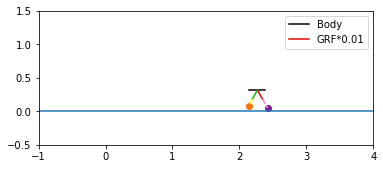

In [24]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_UL = {}
    plot_UR = {}
    plot_footL = {}
    plot_footR = {}
    abs_angles = {}
    
    # plot boom
    #ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="black")

    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    link_colour = ['red','pink','purple','green','yellow','orange']
    
    #plot upper left
    abs_angles.update({('UL'): m.q[i,'theta_body'].value + m.q[i,'theta_UL'].value})
    plot_UL.update({('top','X'): m.q[i,'x_body'].value})
    plot_UL.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UL.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UL']*sin(abs_angles['UL'])})
    plot_UL.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UL']*cos(abs_angles['UL'])})
    ax.plot([plot_UL['top','X'],plot_UL['bot','X']],[plot_UL['top','Y'],plot_UL['bot','Y']],color='xkcd:{0}'.format(link_colour[0]))


    #plot upper right
    abs_angles.update({('UR'): m.q[i,'theta_body'].value + m.q[i,'theta_UR'].value})
    plot_UR.update({('top','X'): m.q[i,'x_body'].value})
    plot_UR.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UR.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UR']*sin(abs_angles['UR'])})
    plot_UR.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UR']*cos(abs_angles['UR'])})
    ax.plot([plot_UR['top','X'],plot_UR['bot','X']],[plot_UR['top','Y'],plot_UR['bot','Y']],color='xkcd:{0}'.format(link_colour[3]))
    
    #plot left foot
    plot_footL.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*sin(abs_angles['UL'])})
    plot_footL.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*cos(abs_angles['UL'])})
    ax.plot(plot_footL['bot','X'],plot_footL['bot','Y'],color='xkcd:{0}'.format(link_colour[2]), marker='o')

    #plot right foot
    plot_footR.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*sin(abs_angles['UR'])})
    plot_footR.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*cos(abs_angles['UR'])})
    ax.plot(plot_footR['bot','X'],plot_footR['bot','Y'],color='xkcd:{0}'.format(link_colour[5]), marker='o')
    
    # virtual prismatic links
    ax.plot([plot_UL['bot','X'],plot_footL['bot','X']],[plot_UL['bot','Y'],plot_footL['bot','Y']],color='xkcd:{0}'.format(link_colour[1]),ls='--')
    ax.plot([plot_UR['bot','X'],plot_footR['bot','X']],[plot_UR['bot','Y'],plot_footR['bot','Y']],color='xkcd:{0}'.format(link_colour[4]),ls='--')
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    if m.GRF_y[i,'footR'].value > 0.0:
        print('GRF_footR = ',m.GRF_y[i,'footR'].value)
        ax.arrow(plot_footR['bot','X'], plot_footR['bot','Y'], 0, 0.01*m.GRF_y[i,'footR'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
        
    if m.GRF_y[i,'footL'].value > 0.0:
        print('GRF_footL = ',m.GRF_y[i,'footL'].value)
        ax.arrow(plot_footL['bot','X'], plot_footL['bot','Y'], 0, 0.01*m.GRF_y[i,'footL'].value,color='xkcd:{0}'.format('red'),head_width = 0.1)
    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 100,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [25]:
print(results.solver.termination_condition) # check if optimal

optimal


In [26]:
f = r"{0}.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
len(N_time)

GRF_footR =  1.6796419057475842e-08
GRF_footR =  4.296686640176418e-08
GRF_footR =  5.818726391193962e-06
GRF_footR =  1.4641113639449502e-05
GRF_footR =  268.67793548451607
GRF_footR =  69.21714136950244
GRF_footR =  97.13956396490957
GRF_footR =  104.23336415181777
GRF_footR =  110.47847319742826
GRF_footR =  114.86148380506334
GRF_footR =  115.73836743441562
GRF_footR =  103.60575680700519
GRF_footR =  90.84991190448778
GRF_footR =  97.33590760697305
GRF_footR =  122.8738783485858
GRF_footR =  129.3858390583653
GRF_footR =  129.76467573967167
GRF_footR =  127.86652019630073
GRF_footR =  124.53613041028362
GRF_footR =  120.38862780069398
GRF_footR =  8.937211418170292e-08
GRF_footR =  2.7344843877229282e-08
GRF_footR =  7.75870123178546e-09


102

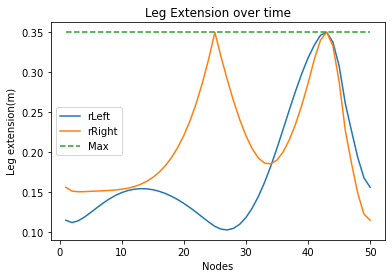

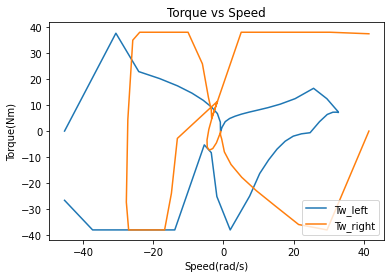

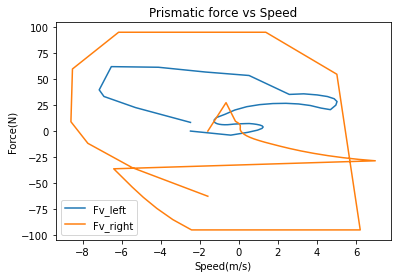

In [21]:
vel = 0.0

rLeft = []
rRight = []
nodes = []
max_extension = []

GRF_y_left = []
GRF_y_right = []

Torque_left = []
Torque_right = []
angular_speed_left = []
angular_speed_right = []

Prismatic_Force_left = []
Prismatic_Force_right = []
Fp_speed_left = []
Fp_speed_right = []

for n in range(1,N+1):
    rLeft.append(m.q[n,'{r_prismatic}_{footL}'].value)
    rRight.append(m.q[n,'{r_prismatic}_{footR}'].value)
    nodes.append(n)
    max_extension.append(0.35)
    
    GRF_y_left.append(m.GRF_y[n,'footL'].value)
    GRF_y_right.append(m.GRF_y[n,'footR'].value)

    Torque_left.append(m.tau_torque[n,'left'].value)
    Torque_right.append(m.tau_torque[n,'right'].value)
    angular_speed_left.append(m.tau_velocity[n,'left'].value)
    angular_speed_right.append(m.tau_velocity[n,'right'].value)

    Prismatic_Force_left.append(m.Fp[n,'left'].value)
    Prismatic_Force_right.append(m.Fp[n,'right'].value)
    Fp_speed_left.append(m.Fp_velocity[n,'left'].value)
    Fp_speed_right.append(m.Fp_velocity[n,'right'].value)
    
    #print(m.q[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
    #print(m.dq[n,'x_body'].value)
    #vel = vel + m.dq[n,'x_body'].value
    #print(m.GRF_y[n,'footL'].value)
    #print(m.tau_torque[n,'left'].value)
    pass

plt.figure()
plt.plot(nodes,rLeft)
plt.plot(nodes,rRight)
plt.plot(nodes,max_extension,linestyle = '--')
plt.title("Leg Extension over time")
plt.ylabel("Leg extension(m)")
plt.xlabel("Nodes")
plt.legend(["rLeft", "rRight","Max"], loc=0, frameon=True)

plt.figure()
plt.plot(angular_speed_left,Torque_left)
plt.plot(angular_speed_right,Torque_right)
plt.title("Torque vs Speed")
plt.ylabel("Torque(Nm)")
plt.xlabel("Speed(rad/s)")
plt.legend(["Tw_left", "Tw_right"], loc=0, frameon=True)

plt.figure()
plt.plot(Fp_speed_left,Prismatic_Force_left)
plt.plot(Fp_speed_right,Prismatic_Force_right)
plt.title("Prismatic force vs Speed")
plt.ylabel("Force(N)")
plt.xlabel("Speed(m/s)")
plt.legend(["Fv_left", "Fv_right"], loc=0, frameon=True)

In [22]:
print(results.solver.termination_condition) # check if optimal

optimal


<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step (select motion)'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

In [23]:
m.mu.value

10.0